In [1]:
%pylab inline
import sys

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.gridspec as gridspec

import matplotlib.font_manager as fm

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
sys.path.append('../')
from mederrata_spmf import PoissonMatrixFactorization


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.


In [2]:
N = 50000
D_factor = 10
D_noise = 20
D = D_factor + D_noise
P = 3

V = np.abs(np.random.normal(1.5, 0.5, size=(P,D_factor)))
Z = np.abs(np.random.normal(0, 1, size=(N,P)))

ZV = Z.dot(V)

X = np.zeros((N, D_factor+D_noise))
X = np.random.poisson(1.,size=(N,D_noise+D_factor))
X[:, ::3] = np.random.poisson(ZV*np.exp(ZV/np.mean(ZV)/10)+(ZV/np.mean(ZV)/10)**2)
# Test taking in from tf.dataset, don't pre-batch
data_structured = tf.data.Dataset.from_tensor_slices(
    {
        'data': X,
        'indices': np.arange(N),
        'normalization': np.ones(N)
    })

data_structured = data_structured.batch(1000)

data_noise = tf.data.Dataset.from_tensor_slices(
    {
        'data': np.random.poisson(1.0, size=(N, D)),
        'indices': np.arange(N),
        'normalization': np.ones(N)
    })

data_noise = data_noise.batch(1000)

X_nonlinear = np.random.poisson(1.,size=(N,D_noise+D_factor))
X_nonlinear[:, ::3] = np.random.poisson(ZV*np.exp(-ZV/np.mean(ZV)/4.)+(ZV/np.mean(ZV)/4.)**2)

data_nonlinear = tf.data.Dataset.from_tensor_slices(
    {
        'data': X_nonlinear,
        'indices': np.arange(N),
        'normalization': np.ones(N)
    })

data_nonlinear = data_nonlinear.batch(1000)


In [3]:
# strategy = tf.distribute.MirroredStrategy()
strategy = None
factor = PoissonMatrixFactorization(
    data_structured, latent_dim=P, strategy=strategy,
    scale_rates=True, with_s=True,
    u_tau_scale=1.0/np.sqrt(D*N),
    dtype=tf.float64)

factor_noise = PoissonMatrixFactorization(
    data_noise, latent_dim=P, strategy=strategy,
    scale_rates=True, with_s=True,
    u_tau_scale=1.0/np.sqrt(D*N),
    dtype=tf.float64)

factor_nonlinear = PoissonMatrixFactorization(
    data_nonlinear, latent_dim=P, strategy=strategy,
    scale_rates=True, with_s=True,
    u_tau_scale=1.0/np.sqrt(D*N),
    dtype=tf.float64)

Feature dim: 30 -> Latent dim 3
Feature dim: 30 -> Latent dim 3
Feature dim: 30 -> Latent dim 3


In [4]:
losses = factor_noise.calibrate_advi(
    num_epochs=200, rel_tol=1e-4, learning_rate=.1)

W0604 09:11:03.165111 4458253760 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Initial loss: 46.31711849543949
Epoch 1: average-batch loss: 43.7410293952114 last batch loss: 43.042385896832336
Saved a checkpoint: ./.tf_ckpts/chkpt-1
Epoch 2: average-batch loss: 42.52372213927176 last batch loss: 41.952291653026684
Saved a checkpoint: ./.tf_ckpts/chkpt-2
Epoch 3: average-batch loss: 41.582225480914296 last batch loss: 41.0888366312795
Saved a checkpoint: ./.tf_ckpts/chkpt-3
Epoch 4: average-batch loss: 40.8480151895427 last batch loss: 40.55134766730372
Saved a checkpoint: ./.tf_ckpts/chkpt-4
Epoch 5: average-batch loss: 40.54365881577268 last batch loss: 40.411172955161916
Saved a checkpoint: ./.tf_ckpts/chkpt-5
Epoch 6: average-batch loss: 40.43214223751251 last batch loss: 40.34313175380768
Saved a checkpoint: ./.tf_ckpts/chkpt-6
Epoch 7: average-batch loss: 40.37050370200359 last batch loss: 40.273024932038055
Saved a checkpoint: ./.tf_ckpts/chkpt-7
Epoch 8: average-batch loss: 40.342723409471255 last batch loss: 40.27076774237394
Saved a checkpoint: ./.tf_ckp

Epoch 76: average-batch loss: 40.32049584324178 last batch loss: 40.25952540853716
Epoch 77: average-batch loss: 40.321620220006665 last batch loss: 40.25524283697703
Epoch 78: average-batch loss: 40.31792328915354 last batch loss: 40.267313386025705
Epoch 79: average-batch loss: 40.31536330561132 last batch loss: 40.2428864969236
Epoch 80: average-batch loss: 40.308739449554345 last batch loss: 40.26160661354793
Epoch 81: average-batch loss: 40.31254434026423 last batch loss: 40.2928373627872
Epoch 82: average-batch loss: 40.31398621661139 last batch loss: 40.24267448387266
We are in a loss plateau learning rate: 0.028242953648100012 loss: 40.348589856900205
Restoring from a checkpoint - loss: 40.34734210702012
Epoch 83: average-batch loss: 40.31432036158623 last batch loss: 40.240119344931216
Epoch 84: average-batch loss: 40.31359029788203 last batch loss: 40.261254285535976
Epoch 85: average-batch loss: 40.31001851355683 last batch loss: 40.2491673734911
Epoch 86: average-batch loss

Epoch 154: average-batch loss: 40.31280814618549 last batch loss: 40.253419615257776
Epoch 155: average-batch loss: 40.3186957092687 last batch loss: 40.2784030262875
Epoch 156: average-batch loss: 40.31658391413802 last batch loss: 40.26675322175352
Epoch 157: average-batch loss: 40.312181618098386 last batch loss: 40.232666294233944
Epoch 158: average-batch loss: 40.308453528418916 last batch loss: 40.25009366435455
Epoch 159: average-batch loss: 40.31611342122856 last batch loss: 40.269292785358395
We are in a loss plateau learning rate: 0.007976644307687256 loss: 40.363010988470485
Restoring from a checkpoint - loss: 40.36480235844436
Epoch 160: average-batch loss: 40.31540182404827 last batch loss: 40.252243298658634
Epoch 161: average-batch loss: 40.31767802665194 last batch loss: 40.26517490797475
Epoch 162: average-batch loss: 40.309983339164404 last batch loss: 40.25266583110049
Epoch 163: average-batch loss: 40.31228842921752 last batch loss: 40.23470310688186
Epoch 164: aver

In [5]:
waic = factor_noise.waic()
print(waic)

{'waic': 353932.84494931763, 'se': 1811.8601142166967, 'lppd': -37825.634589802445, 'pwaic': 139140.78788485637}


In [6]:
losses = factor.calibrate_advi(
    num_epochs=200, rel_tol=1e-4, learning_rate=.1)




Initial loss: 60.68973508624056
Epoch 1: average-batch loss: 56.3720230987765 last batch loss: 55.22081383717899
Saved a checkpoint: ./.tf_ckpts/chkpt-1
Epoch 2: average-batch loss: 55.082912448534145 last batch loss: 54.162403801960714
Saved a checkpoint: ./.tf_ckpts/chkpt-2
Epoch 3: average-batch loss: 54.15355712297716 last batch loss: 53.31761765792192
Saved a checkpoint: ./.tf_ckpts/chkpt-3
Epoch 4: average-batch loss: 53.403993550009666 last batch loss: 52.59896178977851
Saved a checkpoint: ./.tf_ckpts/chkpt-4
Epoch 5: average-batch loss: 52.979769210149215 last batch loss: 52.23694692800408
Saved a checkpoint: ./.tf_ckpts/chkpt-5
Epoch 6: average-batch loss: inf last batch loss: 50.489294432202925
Got NaN, restoring a checkpoint
We are in a loss plateau learning rate: 0.08100000000000002 loss: 52.61801519404851
Restoring from a checkpoint - loss: 52.653317391166404
Epoch 7: average-batch loss: 52.207079565926804 last batch loss: 51.11457552850712
Saved a checkpoint: ./.tf_ckpts/

Epoch 69: average-batch loss: 47.32693087530134 last batch loss: 47.19752911042511
Saved a checkpoint: ./.tf_ckpts/chkpt-39
Epoch 70: average-batch loss: 47.32759735684912 last batch loss: 47.24607962387546
Epoch 71: average-batch loss: 47.325732149146596 last batch loss: 47.20396944395074
Saved a checkpoint: ./.tf_ckpts/chkpt-40
Epoch 72: average-batch loss: 47.32409782042782 last batch loss: 47.22619835778565
Saved a checkpoint: ./.tf_ckpts/chkpt-41
Epoch 73: average-batch loss: 47.330717529277734 last batch loss: 47.20236654744645
We are in a loss plateau learning rate: 0.03874204890000001 loss: 47.13687881386963
Restoring from a checkpoint - loss: 47.16396824104601
Epoch 74: average-batch loss: 47.33219775331197 last batch loss: 47.24533380639455
Epoch 75: average-batch loss: 47.32721372004748 last batch loss: 47.246863852328595
Epoch 76: average-batch loss: 47.32563677234275 last batch loss: 47.26066173859507
Epoch 77: average-batch loss: 47.32726585250423 last batch loss: 47.1777

Epoch 144: average-batch loss: 47.32932112220016 last batch loss: 47.23985780086594
Epoch 145: average-batch loss: 47.338725378729315 last batch loss: 47.231115450551
We are in a loss plateau learning rate: 0.010941898913151242 loss: 47.13844776540554
Restoring from a checkpoint - loss: 47.146791067554574
Epoch 146: average-batch loss: 47.32951279124454 last batch loss: 47.215776998667
Epoch 147: average-batch loss: 47.350958359692314 last batch loss: 47.2323458931215
Epoch 148: average-batch loss: 47.32783407685025 last batch loss: 47.19978890459356
Epoch 149: average-batch loss: 47.32673020366864 last batch loss: 47.19648386795307
Epoch 150: average-batch loss: 47.334510565533236 last batch loss: 47.21694818518671
We are in a loss plateau learning rate: 0.00984770902183612 loss: 47.17972454584809
Restoring from a checkpoint - loss: 47.155766861638796
Epoch 151: average-batch loss: 47.32358623423341 last batch loss: 47.22125508805814
Epoch 152: average-batch loss: 47.33192238284032 la

In [7]:
losses = factor_nonlinear.calibrate_advi(
    num_epochs=200, rel_tol=1e-4, learning_rate=.1)


Initial loss: 54.6392703125668
Epoch 1: average-batch loss: 51.14601513363424 last batch loss: 50.239704978423966
Saved a checkpoint: ./.tf_ckpts/chkpt-1
Epoch 2: average-batch loss: 49.89042928301294 last batch loss: 49.17429576970631
Saved a checkpoint: ./.tf_ckpts/chkpt-2
Epoch 3: average-batch loss: 48.95978751104007 last batch loss: 48.30918832688681
Saved a checkpoint: ./.tf_ckpts/chkpt-3
Epoch 4: average-batch loss: 48.22607947172859 last batch loss: 47.780640145405776
Saved a checkpoint: ./.tf_ckpts/chkpt-4
Epoch 5: average-batch loss: inf last batch loss: 47.574680546370786
Got NaN, restoring a checkpoint
We are in a loss plateau learning rate: 0.08100000000000002 loss: 47.95131362219337
Restoring from a checkpoint - loss: 47.92805659391549
Epoch 6: average-batch loss: 47.915695496963096 last batch loss: 47.628084664272755
Saved a checkpoint: ./.tf_ckpts/chkpt-5
Epoch 7: average-batch loss: 47.782115551386326 last batch loss: 47.441653876132825
Saved a checkpoint: ./.tf_ckpts/

Epoch 72: average-batch loss: 45.603977286139596 last batch loss: 45.49761428033806
Epoch 73: average-batch loss: 45.60488988713442 last batch loss: 45.4677384741601
Epoch 74: average-batch loss: 45.60603743611438 last batch loss: 45.48596283152084
Epoch 75: average-batch loss: 45.613562720048385 last batch loss: 45.45361415225539
Epoch 76: average-batch loss: 45.60353726113015 last batch loss: 45.484326327345826
Epoch 77: average-batch loss: 45.602685126947584 last batch loss: 45.44778091362455
Epoch 78: average-batch loss: 45.59444889044656 last batch loss: 45.51264444588749
Saved a checkpoint: ./.tf_ckpts/chkpt-31
Epoch 79: average-batch loss: 45.595722130295265 last batch loss: 45.467500317631
Epoch 80: average-batch loss: 45.60164356504046 last batch loss: 45.46547350604335
We are in a loss plateau learning rate: 0.031381059609000006 loss: 45.45053241870449
Restoring from a checkpoint - loss: 45.450511060932996
Epoch 81: average-batch loss: 45.600754500615324 last batch loss: 45.4

Epoch 149: average-batch loss: 45.59856504750246 last batch loss: 45.44234434697601
Epoch 150: average-batch loss: 45.59520777057076 last batch loss: 45.462448820935094
Epoch 151: average-batch loss: 45.59851891889459 last batch loss: 45.523273219549274
Epoch 152: average-batch loss: 45.59716541902576 last batch loss: 45.44613884628001
Epoch 153: average-batch loss: 45.59599352864102 last batch loss: 45.45954276710261
Epoch 154: average-batch loss: 45.5996657078885 last batch loss: 45.47882392983274
We are in a loss plateau learning rate: 0.008862938119652507 loss: 45.46161790466939
Restoring from a checkpoint - loss: 45.455196341123
Epoch 155: average-batch loss: 45.594074625495274 last batch loss: 45.45844261449238
Epoch 156: average-batch loss: 45.59811817297973 last batch loss: 45.50565560578467
Epoch 157: average-batch loss: 45.59800354683506 last batch loss: 45.46767308478814
Epoch 158: average-batch loss: 45.59578441104508 last batch loss: 45.46176670486485
Epoch 159: average-ba

In [8]:
surrogate_samples = factor.surrogate_distribution.sample(1000)
if 's' in surrogate_samples.keys():
    weights = surrogate_samples['s']/tf.reduce_sum(surrogate_samples['s'],-2,keepdims=True)
    intercept_data_structured = az.convert_to_inference_data(
        {
            r"": 
                (tf.squeeze(surrogate_samples['w'])*weights[:,-1,:]*factor.column_norm_factor).numpy().T})
else:
    intercept_data_structured = az.convert_to_inference_data(
        {
            r"": 
                (tf.squeeze(surrogate_samples['w'])*factor.column_norm_factor).numpy().T})    

surrogate_samples = factor_noise.surrogate_distribution.sample(1000)
if 's' in surrogate_samples.keys():
    weights = surrogate_samples['s']/tf.reduce_sum(surrogate_samples['s'],-2,keepdims=True)
    intercept_data_noise = az.convert_to_inference_data(
        {
            r"": 
                (tf.squeeze(surrogate_samples['w'])*weights[:,-1,:]*factor_noise.column_norm_factor).numpy().T})
else:
    intercept_data_noise = az.convert_to_inference_data(
        {
            r"": 
                (tf.squeeze(surrogate_samples['w'])*factor_noise.column_norm_factor).numpy().T})


surrogate_samples = factor_nonlinear.surrogate_distribution.sample(1000)
if 's' in surrogate_samples.keys():
    weights = surrogate_samples['s']/tf.reduce_sum(surrogate_samples['s'],-2,keepdims=True)
    intercept_data_nonlinear = az.convert_to_inference_data(
        {
            r"": 
                (tf.squeeze(surrogate_samples['w'])*weights[:,-1,:]*factor_nonlinear.column_norm_factor).numpy().T})
else:
    intercept_data_nonlinear = az.convert_to_inference_data(
        {
            r"": 
                (tf.squeeze(surrogate_samples['w'])*factor_nonlinear.column_norm_factor).numpy().T})   

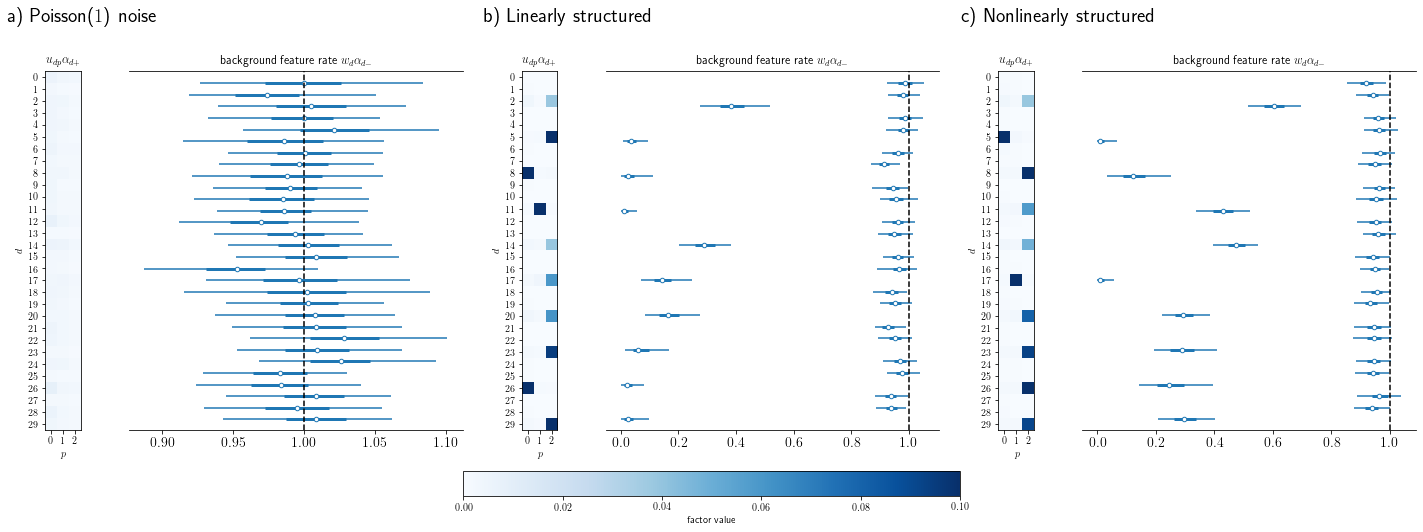

In [9]:
fig = plt.figure(constrained_layout=False, figsize=(20,7.5))
gs = fig.add_gridspec(3, 3, height_ratios=(0.08, 6.5, 0.3))
ax = []

ax += [fig.add_subplot(gs[0,0])]
txt = ax[-1].text(0,0,"a) Poisson($1$) noise", clip_on=False, fontsize=20)
ax[-1].axis('off')

ax += [fig.add_subplot(gs[0,1])]
txt = ax[-1].text(0,0,"b) Linearly structured", clip_on=False, fontsize=20)
ax[-1].axis('off')

ax += [fig.add_subplot(gs[0,2])]
txt = ax[-1].text(0,0,"c) Nonlinearly structured", clip_on=False, fontsize=20)
ax[-1].axis('off')

gs0 = gs[1, 0].subgridspec(1,2, width_ratios=[1,3])
ax+= [fig.add_subplot(gs0[0, 0])]
pcm = ax[-1].imshow(factor_noise.encoding_matrix().numpy()[::-1,:], vmin=0, vmax=0.1, cmap="Blues")
ax[-1].set_title(r"$u_{dp} \alpha_{d+}$")
ax[-1].set_xticks(range(P))
ax[-1].set_yticks(range(D))
ax[-1].set_ylabel(r"$d$")
ax[-1].set_xlabel(r"$p$")
ax[-1].grid(which='minor', color='g', linestyle='-', linewidth=2)
#fig.colorbar(pcm, ax=ax[-1], location='left', shrink=0.5)
#ax[-1].set_title("a) Noise factorization", fontsize=20)

ax+= [fig.add_subplot(gs0[0, 1])]
az.plot_forest(intercept_data_noise, ax=ax[-1])
ax[-1].set_title(r"background feature rate $w_d \alpha_{d-}$")
ax[-1].set_ylim((-0.014,.466))
ax[-1].axvline(1.0, linestyle='dashed', color="black")

#

gs1 = gs[1, 1].subgridspec(1,2, width_ratios=[1,3])
ax = []
ax+= [fig.add_subplot(gs1[0, 0])]


pcm = ax[-1].imshow(factor.encoding_matrix().numpy()[::-1,:], vmin=0, vmax=0.1, cmap="Blues")
ax[-1].set_title(r"$u_{dp} \alpha_{d+}$")

ax[-1].set_xticks(range(P))
ax[-1].set_yticks(range(D))
ax[-1].set_ylabel(r"$d$")
ax[-1].set_xlabel(r"$p$")
#fig.colorbar(pcm, ax=ax[-1], location='left', shrink=0.5)
ax+= [fig.add_subplot(gs1[0, 1])]
az.plot_forest(intercept_data_structured, ax=ax[-1])
ax[-1].set_title(r"background feature rate $w_d \alpha_{d-}$")
ax[-1].set_ylim((-0.014,.466))
ax[-1].axvline(1.0, linestyle='dashed', color="black")

gs2 = gs[1, 2].subgridspec(1,2, width_ratios=[1,3])
ax = []
ax+= [fig.add_subplot(gs2[0, 0])]
pcm = ax[-1].imshow(factor_nonlinear.encoding_matrix().numpy()[::-1,:], vmin=0, vmax=0.1, cmap="Blues")
ax[-1].set_title(r"$u_{dp} \alpha_{d+}$")

ax[-1].set_xticks(range(P))
ax[-1].set_yticks(range(D))
ax[-1].set_ylabel(r"$d$")
ax[-1].set_xlabel(r"$p$")
#fig.colorbar(pcm, ax=ax[-1], location='left', shrink=0.5)
#ax[-1].set_title("a) Noise factorization", fontsize=20)

ax+= [fig.add_subplot(gs2[0, 1])]
az.plot_forest(intercept_data_nonlinear, ax=ax[-1])
#ax[-1].set_xlabel("background rate")
ax[-1].set_ylim((-0.014,.466))
ax[-1].set_title(r"background feature rate $w_d \alpha_{d-}$")
ax[-1].axvline(1.0, linestyle='dashed', color="black")

# colorbar

ax += [fig.add_subplot(gs[2, :])]
ax[-1].set_axis_off()
fig.colorbar(pcm, ax=ax[-1], orientation="horizontal", fraction=1.5, label="factor value")


plt.tight_layout()
plt.savefig('simulations_sepmf.pdf', bbox_inches='tight')
